In [ ]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pprint     
pprint.pprint(sys.path)
!python -c "import site; print (site.getsitepackages())"

In [ ]:
pip install spektral

In [3]:
# import useful packages and functions
from spektral_package import *

In [4]:
import networkx as nx
import numpy as np
from scipy import sparse as sp

try:
    from rdkit import Chem as rdc
    from rdkit.Chem import Draw
    from rdkit import rdBase as rdb

    rdb.DisableLog('rdApp.error')  # RDKit logging is disabled by default
    Draw.DrawingOptions.dblBondOffset = .1
    BOND_MAP = {0: rdc.rdchem.BondType.ZERO,
                1: rdc.rdchem.BondType.SINGLE,
                2: rdc.rdchem.BondType.DOUBLE,
                3: rdc.rdchem.BondType.TRIPLE,
                4: rdc.rdchem.BondType.AROMATIC}
except ImportError:
    rdc = None
    rdb = None

NUM_TO_SYMBOL = {1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N',
                 8: 'O', 9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al',
                 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar', 19: 'K',
                 20: 'Ca', 21: 'Sc', 22: 'Ti', 23: 'V', 24: 'Cr', 25: 'Mn',
                 26: 'Fe', 27: 'Co', 28: 'Ni', 29: 'Cu', 30: 'Zn', 31: 'Ga',
                 32: 'Ge', 33: 'As', 34: 'Se', 35: 'Br', 36: 'Kr', 37: 'Rb',
                 38: 'Sr', 39: 'Y', 40: 'Zr', 41: 'Nb', 42: 'Mo', 43: 'Tc',
                 44: 'Ru', 45: 'Rh', 46: 'Pd', 47: 'Ag', 48: 'Cd', 49: 'In',
                 50: 'Sn', 51: 'Sb', 52: 'Te', 53: 'I', 54: 'Xe', 55: 'Cs',
                 56: 'Ba', 57: 'La', 58: 'Ce', 59: 'Pr', 60: 'Nd', 61: 'Pm',
                 62: 'Sm', 63: 'Eu', 64: 'Gd', 65: 'Tb', 66: 'Dy', 67: 'Ho',
                 68: 'Er', 69: 'Tm', 70: 'Yb', 71: 'Lu', 72: 'Hf', 73: 'Ta',
                 74: 'W', 75: 'Re', 76: 'Os', 77: 'Ir', 78: 'Pt', 79: 'Au',
                 80: 'Hg', 81: 'Tl', 82: 'Pb', 83: 'Bi', 84: 'Po', 85: 'At',
                 86: 'Rn', 87: 'Fr', 88: 'Ra', 89: 'Ac', 90: 'Th', 91: 'Pa',
                 92: 'U', 93: 'Np', 94: 'Pu', 95: 'Am', 96: 'Cm', 97: 'Bk',
                 98: 'Cf', 99: 'Es', 100: 'Fm', 101: 'Md', 102: 'No', 103: 'Lr',
                 104: 'Rf', 105: 'Db', 106: 'Sg', 107: 'Bh', 108: 'Hs',
                 109: 'Mt', 110: 'Ds', 111: 'Rg', 112: 'Cn', 113: 'Nh',
                 114: 'Fl', 115: 'Mc', 116: 'Lv', 117: 'Ts', 118: 'Og'}
SYMBOL_TO_NUM = {v: k for k, v in NUM_TO_SYMBOL.items()}


def numpy_to_rdkit(adj, nf, ef, sanitize=False):
    """
    Converts a molecule from numpy to RDKit format.
    :param adj: binary numpy array of shape (N, N)
    :param nf: numpy array of shape (N, F)
    :param ef: numpy array of shape (N, N, S)
    :param sanitize: whether to sanitize the molecule after conversion
    :return: an RDKit molecule
    """
    if rdc is None:
        raise ImportError('`numpy_to_rdkit` requires RDKit.')
    mol = rdc.RWMol()
    for nf_ in nf:
        atomic_num = int(nf_)
        if atomic_num > 0:
            mol.AddAtom(rdc.Atom(atomic_num))

    for i, j in zip(*np.triu_indices(adj.shape[-1])):
        if i != j and adj[i, j] == adj[j, i] == 1 and not mol.GetBondBetweenAtoms(int(i), int(j)):
            bond_type_1 = BOND_MAP[int(ef[i, j, 0])]
            bond_type_2 = BOND_MAP[int(ef[j, i, 0])]
            if bond_type_1 == bond_type_2:
                mol.AddBond(int(i), int(j), bond_type_1)

    mol = mol.GetMol()
    if sanitize:
        rdc.SanitizeMol(mol)
    return mol


def numpy_to_smiles(adj, nf, ef):
    """
    Converts a molecule from numpy to SMILES format.
    :param adj: binary numpy array of shape (N, N)
    :param nf: numpy array of shape (N, F)
    :param ef: numpy array of shape (N, N, S)
    :return: the SMILES string of the molecule
    """
    if rdc is None:
        raise ImportError('`numpy_to_smiles` requires RDkit.')
    mol = numpy_to_rdkit(adj, nf, ef)
    return rdkit_to_smiles(mol)


def rdkit_to_smiles(mol):
    """
    Returns the SMILES string representing an RDKit molecule.
    :param mol: an RDKit molecule
    :return: the SMILES string of the molecule
    """
    if rdc is None:
        raise ImportError('`rdkit_to_smiles` requires RDkit.')
    return rdc.MolToSmiles(mol)


def sdf_to_nx(sdf, keep_hydrogen=False):
    """
    Converts molecules in SDF format to networkx Graphs.
    :param sdf: a list of molecules (or individual molecule) in SDF format.
    :param keep_hydrogen: whether to include hydrogen in the representation.
    :return: list of nx.Graphs.
    """
    if not isinstance(sdf, list):
        sdf = [sdf]

    output = []
    for sdf_ in sdf:
        g = nx.Graph()

        for atom in sdf_['atoms']:
            if atom['atomic_num'] > 1 or keep_hydrogen:
                g.add_node(atom['index'], **atom)
        for bond in sdf_['bonds']:
            start_atom_num = sdf_['atoms'][bond['start_atom']]['atomic_num']
            end_atom_num = sdf_['atoms'][bond['end_atom']]['atomic_num']
            if (start_atom_num > 1 and end_atom_num > 1) or keep_hydrogen:
                g.add_edge(bond['start_atom'], bond['end_atom'], **bond)
        output.append(g)

    if len(output) == 1:
        return output[0]
    else:
        return output


def nx_to_sdf(graphs):
    """
    Converts a list of nx.Graphs to the internal SDF format.
    :param graphs: list of nx.Graphs.
    :return: list of molecules in the internal SDF format.
    """
    if isinstance(graphs, nx.Graph):
        graphs = [graphs]
    output = []
    for g in graphs:
        sdf = {'atoms': [v for k, v in g.nodes.items()],
               'bonds': [v for k, v in g.edges.items()],
               'comment': '',
               'data': [''],
               'details': '',
               'n_atoms': -1,
               'n_bonds': -1,
               'name': '',
               'properties': []}
        output.append(sdf)
    return output


def validate_rdkit_mol(mol):
    """
    Sanitizes an RDKit molecules and returns True if the molecule is chemically
    valid.
    :param mol: an RDKit molecule
    :return: True if the molecule is chemically valid, False otherwise
    """
    if rdc is None:
        raise ImportError('`validate_rdkit_mol` requires RDkit.')
    if len(rdc.GetMolFrags(mol)) > 1:
        return False
    try:
        rdc.SanitizeMol(mol)
        return True
    except ValueError:
        return False


def validate_rdkit(mol):
    """
    Validates RDKit molecules (single or in a list).
    :param mol: an RDKit molecule or list/np.array thereof
    :return: boolean array, True if the molecules are chemically valid, False
    otherwise
    """
    if rdc is None:
        raise ImportError('`validate_rdkit` requires RDkit.')
    if isinstance(mol, list) or isinstance(mol, np.ndarray):
        return np.array([validate_rdkit_mol(m) for m in mol])
    else:
        return validate_rdkit_mol(mol)

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
import pandas as pd
df = pd.read_csv('top_20_MOAs.txt', sep = '\t')
df

,SMILES,MOA
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist
...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist


In [7]:
# check the duplicates 
for i in df.SMILES.tolist():
  if df.SMILES.tolist().count(i) != 1:
    print(i)

In [8]:
MOA_class_dictionary = {'EGFR inhibitor': 8,
 'HDAC inhibitor': 16,
 'PI3K inhibitor': 13,
 'acetylcholine receptor agonist': 1,
 'acetylcholine receptor antagonist': 4,
 'adrenergic receptor agonist': 18,
 'adrenergic receptor antagonist': 15,
 'bacterial cell wall synthesis inhibitor': 14,
 'benzodiazepine receptor agonist': 10,
 'calcium channel blocker': 5,
 'cyclooxygenase inhibitor': 6,
 'dopamine receptor antagonist': 12,
 'glucocorticoid receptor agonist': 9,
 'glutamate receptor antagonist': 19,
 'histamine receptor antagonist': 17,
 'phosphodiesterase inhibitor': 3,
 'serotonin receptor agonist': 7,
 'serotonin receptor antagonist': 2,
 'sodium channel blocker': 11,
 'topoisomerase inhibitor': 0}

In [9]:
sorted_classes = list(MOA_class_dictionary.values())
sorted_classes.sort() 
assert sorted_classes == [i for i in range(20)]

In [10]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]
df

,SMILES,MOA,classes
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist,15
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist,15
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist,15
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist,15
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist,15
...,...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist,10
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist,10
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist,10
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist,10


In [11]:
# A function that changes smiles string to fingerprints 
import rdkit
import numpy as np
from rdkit import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
def smiles_to_array_to_string(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays  = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = list((np.squeeze(x_array)).astype(int))
  string = ''
  for i in x_array:
    string += str(i) 
  return string

In [12]:
# Check the existence of Isomers
assert len(set([smiles_to_array_to_string(i) for i in df.SMILES.tolist()])) == df.shape[0]

In [13]:
df

,SMILES,MOA,classes
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist,15
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist,15
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist,15
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist,15
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist,15
...,...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist,10
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist,10
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist,10
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist,10


In [14]:
structures = df.SMILES.tolist()

In [15]:
molecule_blocks = []
for structure in structures:
  molecule = Chem.MolFromSmiles(structure)
  molecule_block = Chem.MolToMolBlock(molecule)
  molecule_blocks.append(molecule_block)

In [16]:
molecule_textfile = open("molecule_textfile.txt", "w")
for molecule_block in molecule_blocks:
  molecule_textfile.write(molecule_block + "\n" + '$$$$' + "\n")
molecule_textfile.close()

In [17]:
from spektral.utils.io import load_sdf
molecule_sdf_loaded = load_sdf("molecule_textfile.txt", amount = None)

Reading SDF


In [18]:
import networkx as nx
molecule_sdf_nx = sdf_to_nx(molecule_sdf_loaded, keep_hydrogen = True)

In [19]:
molecule_sdf_adj, molecule_sdf_node, _ = nx_to_numpy(molecule_sdf_nx, nf_keys=['atomic_num'],ef_keys=['type'] )

In [20]:
uniq_node = np.unique([v for x in molecule_sdf_node for v in np.unique(x)])
node = [label_to_one_hot(x, uniq_node) for x in molecule_sdf_node]

In [21]:
y = [int(i) for i in df['classes'].tolist()]

In [22]:
n_nodes = node[0].shape[-2]           
n_features = node[0].shape[-1]         
n_classes = len(set(y))    

In [23]:
X = list(df.index)

In [24]:
# Split out the test set    
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test= train_test_split(X, df.classes.tolist(), test_size =10/100,
      stratify = df.classes.tolist(), shuffle=True, random_state = 1000)

In [25]:
# kfold 
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)

In [26]:
number_of_kfold = 0 # Change this from 0-8 to get 9 shuffles 

In [27]:
x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
x_test = list(x_test)
y_test = list(y_test)

In [28]:
# Get adjacency matrix       
A_train = molecule_sdf_adj[x_train]
A_valid = molecule_sdf_adj[x_valid]
A_test = molecule_sdf_adj[x_test]

In [29]:
# get node matrix   
X_train = []
for i in  x_train:
  X_train.append(node[i])

In [30]:
X_valid = []
for i in  x_valid:
  X_valid.append(node[i]) 

In [31]:
X_test = []
for i in x_test:
  X_test.append(node[i])  

In [32]:
# Check the overlap 
for i in x_train:
  if i in x_valid:
    print(i)

In [33]:
for i in x_test:
  if i in x_train:
    print(i)

In [34]:
for i in x_test:
  if i in x_valid:
    print(i)

In [35]:
X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)

In [36]:
from tensorflow.keras.regularizers import l2
from spektral.layers import GCSConv, GlobalAttentionPool
from keras.layers import Dropout, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

units = 128
drop = 0.5
batch_size = 8
l2_reg = 5e-4

X_in = Input((n_nodes, n_features))
A_in = Input((n_nodes, n_nodes))
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, A_in])
layer = Dropout(drop)(layer)
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([layer, A_in])
layer = Dropout(drop)(layer)
layer = GCSConv(units, activation='relu', kernel_regularizer=l2(l2_reg))([layer, A_in])
layer = Dropout(drop)(layer) 
layer = GlobalAttentionPool(units*2)(layer)
output = Dense(n_classes, activation='softmax')(layer)

model0 = Model(inputs = [X_in, A_in], outputs = output)
optimizer = Adam(lr = 1e-3)
model0.compile(optimizer = optimizer,loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
# Create class weights
from sklearn.utils import class_weight
y_unique = np.unique(np.array(y_train))
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = y_unique,
                y = np.array(y_train)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: 1.6266666666666667,
 1: 1.4352941176470588,
 2: 0.8872727272727273,
 3: 0.976,
 4: 0.7283582089552239,
 5: 1.3555555555555556,
 6: 0.6177215189873417,
 7: 0.9959183673469387,
 8: 1.525,
 9: 1.318918918918919,
 10: 1.7428571428571429,
 11: 1.5741935483870968,
 12: 0.976,
 13: 1.4352941176470588,
 14: 0.6506666666666666,
 15: 0.6506666666666666,
 16: 1.5741935483870968,
 17: 0.8714285714285714,
 18: 0.7283582089552239,
 19: 0.8133333333333334}

In [40]:
from keras.callbacks import ModelCheckpoint
filepath_gcn = '/content/'+'GCN_top_'+str(n_classes)+'_MOA_weights.hdf5'
checkpoint_gcn = ModelCheckpoint(filepath_gcn, save_weights_only = True, monitor = 'val_accuracy',
         verbose = 0, save_best_only = True, mode = 'max')

In [41]:
import gc
gc.collect()

3824

In [42]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 80, verbose = 1, mode = 'min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', 
          factor = 0.98, patience = 5, verbose = 0, min_delta = 1e-54, mode = 'min')
history = model0.fit([[X_train, A_train]], np.array(y_train), batch_size = batch_size,
          validation_data = [[X_valid, A_valid], np.array(y_valid)], 
          shuffle = True, class_weight = class_weights_dict45, epochs = 300, 
          verbose = 2, callbacks = [earlyStopping, checkpoint_gcn, reduce_lr_loss,])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


122/122 - 2s - loss: 10.4784 - accuracy: 0.0676 - val_loss: 4.1301 - val_accuracy: 0.0820 - lr: 0.0010 - 2s/epoch - 19ms/step
Epoch 2/300
122/122 - 1s - loss: 3.8252 - accuracy: 0.0953 - val_loss: 3.8241 - val_accuracy: 0.0410 - lr: 0.0010 - 541ms/epoch - 4ms/step
Epoch 3/300
122/122 - 1s - loss: 3.3747 - accuracy: 0.1158 - val_loss: 3.5669 - val_accuracy: 0.0738 - lr: 0.0010 - 543ms/epoch - 4ms/step
Epoch 4/300
122/122 - 1s - loss: 3.2394 - accuracy: 0.1219 - val_loss: 3.4519 - val_accuracy: 0.0492 - lr: 0.0010 - 540ms/epoch - 4ms/step
Epoch 5/300
122/122 - 1s - loss: 3.2027 - accuracy: 0.1250 - val_loss: 3.3789 - val_accuracy: 0.0902 - lr: 0.0010 - 578ms/epoch - 5ms/step
Epoch 6/300
122/122 - 1s - loss: 3.1322 - accuracy: 0.1701 - val_loss: 3.2707 - val_accuracy: 0.1066 - lr: 0.0010 - 563ms/epoch - 5ms/step
Epoch 7/300
122/122 - 1s - loss: 3.1214 - accuracy: 0.1639 - val_loss: 3.3800 - val_accuracy: 0.0656 - lr: 0.0010 - 559ms/epoch - 5ms/step
Epoch 8/300
122/122 - 1s - loss: 3.0831 

In [43]:
# Load the weights 
model0.load_weights(filepath_gcn)

In [44]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [14, 12, 6, 13, 14]
print(classification_report(y_valid, np.array(model0.predict([X_valid, A_valid]).argmax(-1)),))
print(classification_report(y_test, np.array(model0.predict([X_test, A_test]).argmax(-1)),))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.60      0.75         5
           2       0.50      0.14      0.22         7
           3       0.71      0.83      0.77         6
           4       0.57      0.50      0.53         8
           5       0.75      0.60      0.67         5
           6       0.78      0.70      0.74        10
           7       0.33      0.50      0.40         6
           8       0.60      0.75      0.67         4
           9       1.00      0.75      0.86         4
          10       0.25      0.33      0.29         3
          11       0.00      0.00      0.00         4
          12       0.56      0.71      0.63         7
          13       1.00      1.00      1.00         4
          14       0.90      0.90      0.90        10
          15       0.83      0.50      0.62        10
          16       0.80      1.00      0.89         4
          17       0.50    

In [45]:
number_of_kfold,  y_train[0:5],   y_valid[0:5],  (y_test[0:5])

(0, [8, 15, 9, 8, 15], [11, 15, 4, 15, 6], [14, 12, 6, 13, 14])

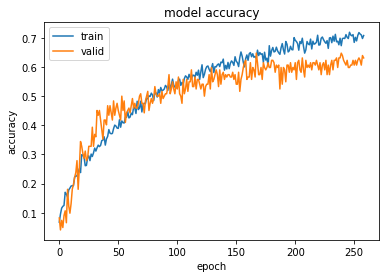

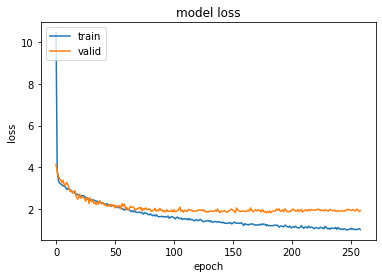

In [46]:
# Training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [49]:
# References 
# https://codesuche.com/view-source/python/danielegrattarola/spektral/ 
# https://github.com/Discngine/dng_dl_speknn 
# https://github.com/danielegrattarola/spektral